In [1]:
# Library imports
import cv2
import imageio
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
# import warnings

# File imports
from k_means import *
from gmm import *

# Example GMM and K-Means with Libraries

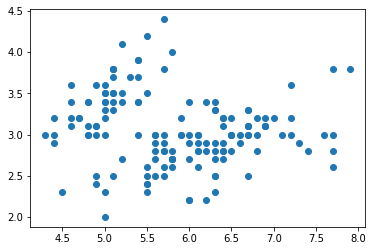

In [2]:
import pandas as pd
from pandas import DataFrame
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
 
# load the iris dataset
iris = datasets.load_iris()
 
# select first two columns 
X = iris.data[:, :2]
 
# turn it into a dataframe
d = pd.DataFrame(X)
 
# plot the data
plt.scatter(d[0], d[1])
plt.show()

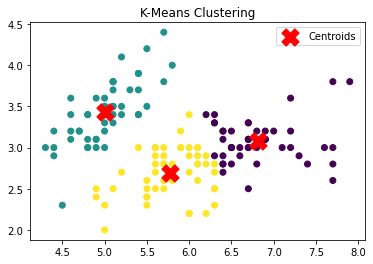

In [3]:
d = pd.DataFrame(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, n_init='auto')  # Assuming you want to divide the data into 3 clusters
kmeans.fit(X)
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
d['Cluster'] = labels

# Plot the data with different colors for each cluster
plt.scatter(d[0], d[1], c=d['Cluster'], cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

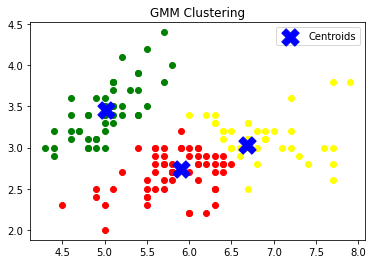

In [4]:
d = pd.DataFrame(X)

# Fit the GMM model for the dataset 
gmm = GaussianMixture(n_components = 3)
gmm.fit(d)
 
# Assign a label to each sample
labels = gmm.predict(d)
d['labels']= labels
d0 = d[d['labels']== 0]
d1 = d[d['labels']== 1]
d2 = d[d['labels']== 2]
 
# plot three clusters in same plot

plt.scatter(d0[0], d0[1], c ='r')
plt.scatter(d1[0], d1[1], c ='yellow')
plt.scatter(d2[0], d2[1], c ='g')

plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=300, c='blue', marker='X', label='Centroids')
plt.title('GMM Clustering')
plt.legend()
plt.show()

# Our K-Means

Iteration at breakage: 13


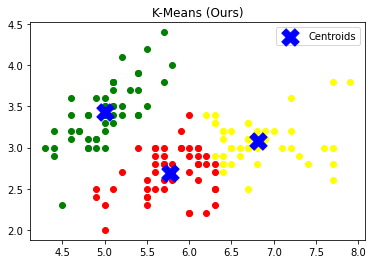

In [5]:
# Run K-Means++
num_classes, num_dimensions = 3, 2
init_c = kmeans_plusplus_initialization(X, num_classes)
means, points = k_means(X, init_c, num_classes)

# Display the points in respective class
colors = ['red', 'yellow', 'green', 'blue']
for k in range(num_classes):
    for point in points[k]:
        plt.scatter(point[0], point[1], c=colors[k])

# Visualization Stuff
plt.scatter(means[:, 0], means[:, 1], s=300, c='blue', marker='X', label='Centroids')
plt.title("K-Means (Ours)")
plt.legend()
plt.show()

# Our GMM Code

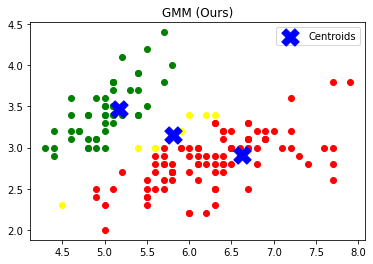

In [6]:
num_classes = 3
n, d = X.shape
posteriors, means, covs, priors = GMM(X, num_classes, 50)

# Give assignment for each point
assignments = np.zeros(n, dtype=int)
for i in range(n):
    assignments[i] = np.argmax(posteriors[i])
    
# Put point into class list
class_points = [[] for _ in range(num_classes)]
for i, assignment in enumerate(assignments):
    class_points[assignment].append(X[i])
    
# Display the points in respective class
colors = ['red', 'yellow', 'green', 'blue']
for k in range(num_classes):
    points = np.array(class_points[k])
    if len(points) == 0:
        print("Problem there are 0 points for class", k)
        continue

    plt.scatter(points[:, 0], points[:, 1], c=colors[k])
plt.scatter(means[:, 0], means[:, 1], s=300, c='blue', marker='X', label='Centroids')
    
plt.title("GMM (Ours)")
plt.legend()
plt.show()

# Testing (Up/Down/Right/Left) on Video Data

In [7]:
def video_to_tensor(video_path, frame_step, down_sample_ratio, frame_offset, frame_trim):
    # Read the video using imageio
    video = imageio.get_reader(video_path)

    # Get video properties
    fps = video.get_meta_data()['fps']
    frame_count = video.count_frames()
    height, width = video.get_data(0).shape[:2]
    channels = 3

    # Create a 4D NumPy array to store video frames
    video_matrix = np.zeros(((49 - frame_offset - frame_trim) // frame_step, 
                             int(height * down_sample_ratio), 
                             int(width * down_sample_ratio), 
                             channels), dtype=np.uint8)

    # Read and store each frame in the matrix
    for i in range(frame_offset, frame_count - frame_trim, frame_step):
        frame = video.get_data(i)
        small_frame = cv2.resize(frame, 
                                 (0,0),
                                 fx=down_sample_ratio, 
                                 fy=down_sample_ratio, 
                                 interpolation=cv2.INTER_CUBIC)
        
        video_matrix[(i - frame_offset) // frame_step] = small_frame

    return video_matrix


In [14]:
# Sample metadata
directories = ['down', 'up', 'right', 'left']
class_counts = 40
num_samples = len(directories) * class_counts

test_split = 0.75
num_training = int(num_samples * test_split)
num_testing = int(num_samples * (1 - test_split))

frame_step = 3
frame_offset = 15
frame_trim = 10
frame_count = ((49 - frame_offset - frame_trim) // frame_step)

down_sample_ratio = 0.05
height = int(480 * down_sample_ratio)
width = int(640 * down_sample_ratio)
channels = 3

# Declare samples array
training = np.zeros((num_training, frame_count, height, width, channels), dtype=np.uint8)
testing = np.zeros((num_testing, frame_count, height, width, channels), dtype=np.uint8)

# Read in all samples (~24s)
training_idx, test_idx = 0, 0
not_highlighter = 40
for directory in directories:
    print("Starting", directory)
    for i in range(not_highlighter + 1, not_highlighter + class_counts + 1):
        if i <= not_highlighter + int(class_counts * test_split):
            training[training_idx] = video_to_tensor('data/' + directory + '/video_' + str(i) + '.mp4', 
                                        frame_step,
                                        down_sample_ratio,
                                        frame_offset,
                                        frame_trim)
            training_idx += 1
        else:
            testing[test_idx] = video_to_tensor('data/' + directory + '/video_' + str(i) + '.mp4', 
                                        frame_step,
                                        down_sample_ratio,
                                        frame_offset,
                                        frame_trim)
            test_idx += 1


Starting down
Starting up
Starting right
Starting left


Frame Shape:  (8, 24, 32, 3)


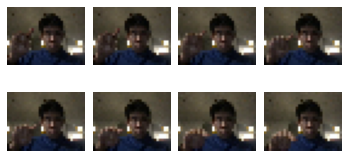

In [15]:
def display_plots(components, num_components=8):
    # Create a 6x6 grid of subplots
    print("Frame Shape: ", components.shape)
    on_row = 4
    _, axes = plt.subplots(2, on_row, figsize=(6, 3))

    # Loop through each subplot and display the vector as an image
    for i in range(num_components):
        ax = axes[i // on_row, i % on_row]
        ax.imshow(components[i])
        ax.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

display_plots(training[1])

In [16]:
def computeGaussian(x, mean, covariance, dim):
  # print(x.shape, mean.shape)
  exponent = -.5 * np.dot(np.dot((x - mean).T, np.linalg.inv(covariance)), (x - mean))
  numerator = np.exp(exponent)
  denominator = (2 * np.pi)**dim * np.linalg.det(covariance)**.5

  return numerator / (denominator)

In [17]:
training = training.reshape(120, 18432)
testing = testing.reshape(40, 18432)
print(testing.shape)

normalized_training = training - np.mean(training)
normalized_testing = testing - np.mean(testing)

print(normalized_testing.shape)

pca = PCA(n_components = 20)
pca.fit(normalized_training)

reduced_testing = pca.transform(normalized_testing)

correct = 0
total = class_counts * (1 - test_split) * 4

direction_means = []
direction_covariances = []
for i in range(len(directories)):
    start = int(i * (class_counts * test_split))
    end = int((i+1) * (class_counts * test_split))
    direction_training = pca.transform(normalized_training[start:end])

    direction_means.append(np.mean(direction_training, axis=0))
    direction_covariances.append(np.cov(direction_training, rowvar=False))

classified = []
for each in reduced_testing:
    classifications = []
    for i in range(len(directories)):
        classifications.append(computeGaussian(each, direction_means[i], direction_covariances[i], 20))

    classified.append(np.argmax(classifications))


for i, each in enumerate(classified):
    if i < 10:
        if each == 0:
            correct += 1
    elif i < 20:
        if each == 1:
            correct += 1
    elif i < 30:
        if each == 2:
            correct += 1
    else:
        if each == 3:
            correct += 1

print(correct/total)


(40, 18432)
(40, 18432)
0.575
